## Tutoriel : Télécharger, prétraiter et analyser les observations satellitaires de précipitations HSAF H60B
Ce tutoriel vous guide pas à pas pour :

1. Télécharger les fichiers H60B depuis le serveur HSAF.

2. Prétraiter les données pour qu’elles soient utilisables dans vos analyses (ex. régrillage en latitude/longitude, extraction d’une zone d’intérêt).

3. Analyser les précipitations pour des points spécifiques ou pour toute une région, incluant la visualisation et le calcul de cumul.

L’objectif est de vous familiariser avec les fichiers HSAF H60B. 

Qu’est-ce que HSAF H60B?
- H60B donne des estimations de pluie à partir des données du satellite MSG SEVIRI.
- Les informations sont mises à jour toutes les 15 minutes pour l’Afrique et l’Europe.

# Étape 1 : Importer les bibliothèques nécessaires

In [1]:
# Bibliothèques de base
import os
import gzip
import shutil
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import math
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import pandas as pd

# Bibliothèques pour la reprojection (changement de système de coordonnées géographiques)
import rioxarray 
from pyproj import CRS
from pyresample.geometry import AreaDefinition
try:
    from satpy.readers.core._geos_area import get_area_extent
except ImportError:
    from satpy.readers._geos_area import get_area_extent

# Bibliothèques pour la gestion des données et des fichiers
from pathlib import Path
from datetime import datetime, timedelta, date
from ftplib import FTP   # Pour télécharger les fichiers depuis un serveur FTP
import re
import warnings

# Supprimer/ignorer les avertissements pour avoir une sortie plus propre
warnings.filterwarnings("ignore")

print("Toutes les bibliothèques ont été importées avec succès!")

Toutes les bibliothèques ont été importées avec succès!


# Étape 2 : Configurer les dossiers de données
Organiser la structure des dossiers de données avec des chemins relatifs

In [2]:
# Créer des dossiers pour nos données
data_folder = Path("./h60b_data")
raw_folder = data_folder / "raw"
processed_folder = data_folder / "processed"

# Créer les répertoires s'ils n'existent pas encore
raw_folder.mkdir(parents=True, exist_ok=True)
processed_folder.mkdir(parents=True, exist_ok=True)

print(f"Dossiers de données créés :")
print(f"Données brutes : {raw_folder}")
print(f"Données traitées : {processed_folder}")

Dossiers de données créés :
Données brutes : h60b_data/raw
Données traitées : h60b_data/processed


# Étape 3 : Configuration de la connexion FTP
- Vous devez vous inscrire sur https://hsaf.meteoam.it/User/Register pour obtenir des identifiants
- Définir le nom du serveur FTP, le dossier sur le serveur FTP, ainsi que le nom d'utilisateur et le mot de passe
- FTP (File Transfer Protocol) est un protocole qui permet de transférer des fichiers entre un ordinateur local et un serveur distant sur Internet.

In [3]:
# Détails du serveur FTP HSAF
ftp_server = "ftphsaf.meteoam.it"
ftp_directory = "./h60B/h60_cur_mon_data/"

# Pour ce tutoriel, nous utilisons des identifiants d'exemple
username = "v.glas@hkv.nl"  			# Remplacez par votre nom d'utilisateur réel
password = "HKV_amersfoort_VG1!"        # Remplacez par votre mot de passe réel

print(f"Serveur FTP : {ftp_server}")
print(f"Dossier sur le serveur FTP : {ftp_directory}")
print("Note : N'oubliez pas de remplacer le nom d'utilisateur/mot de passe par vos identifiants HSAF réels !")

Serveur FTP : ftphsaf.meteoam.it
Dossier sur le serveur FTP : ./h60B/h60_cur_mon_data/
Note : N'oubliez pas de remplacer le nom d'utilisateur/mot de passe par vos identifiants HSAF réels !


# Étape 4 : Se connecter au serveur FTP et lister les fichiers disponibles
Cette étape est utile pour savoir quels fichiers vous pouvez télécharger avant de les traiter.
Ici, nous utilisons la bibliothèque ftplib pour :
1. Se connecter au serveur FTP HSAF avec vos identifiants
2. Accéder au dossier contenant les fichiers H60B
3. Lister tous les fichiers disponibles dans ce dossier

In [4]:
def parse_h60b_timestamp(filename):
    """
    Extraire le timestamp à partir du nom de fichier H60B.

    Les fichiers H60B disponibles sur le serveur HSAF contiennent dans leur nom une indication de date et d'heure sous la forme :h60B_YYYYMMDD_HHMM_xxx.nc

    Cette fonction permet d'extraire ces informations et de les convertir en objet datetime Python, afin de pouvoir trier les fichiers,
    sélectionner des intervalles de temps, ou effectuer toute autre manipulation temporelle dans le script.
    """
    try:
        # Diviser le nom du fichier par "_"
        parts = filename.split("_")
        date_str = parts[1]                  # YYYYMMDD
        time_str = parts[2].split(".")[0]    # HHMM
        # Combiner la date et l'heure et convertir en objet datetime
        timestamp = datetime.strptime(f"{date_str}{time_str}", "%Y%m%d%H%M")
        return timestamp
    except:
        # Si le nom de fichier n'est pas valide, retourner None
        return None

In [5]:
def list_h60b_files_full():
    """
    Lister tous les fichiers H60B disponibles sur le serveur FTP HSAF
    et afficher le premier et le dernier fichier disponibles.

    Les fichiers H60B sur le serveur HSAF ne sont conservés que pour les derniers mois.
    Cette fonction permet de :
      1. Se connecter au serveur FTP HSAF avec vos identifiants.
      2. Lister tous les fichiers H60B présents dans le répertoire.
      3. Extraire la date et l'heure de chaque fichier à partir de son nom.
      4. Identifier le premier et le dernier fichier disponible.

    Cette opération est importante pour connaître la période de disponibilité
    des données H60B avant de lancer une analyse ou de sélectionner des fichiers
    pour une plage temporelle spécifique. 
    """
    try:
        print("Connexion au serveur FTP HSAF...")
        with FTP(ftp_server) as ftp:
            # Se connecter avec les identifiants
            ftp.login(username, password)
            print("Connexion réussie !")
            
            # Aller dans le répertoire où se trouvent les fichiers H60B
            ftp.cwd(ftp_directory)
            print(f"Répertoire actuel sur le serveur : {ftp_directory}")
            
            # Récupérer la liste de tous les fichiers du répertoire
            files = []
            ftp.dir(lambda line: files.append(line.split()[-1]))
            
            # Ne garder que les fichiers H60B (commençant par 'h60')
            h60b_files = [f for f in files if f.startswith("h60")]
            print(f"{len(h60b_files)} fichiers H60B trouvés sur le serveur")
            
            # Extraire les timestamps et filtrer les fichiers invalides
            timestamps_files = [(parse_h60b_timestamp(f), f) 
                                for f in h60b_files 
                                if parse_h60b_timestamp(f) is not None]
            
            if not timestamps_files:
                print("Aucun fichier avec timestamp valide trouvé.")
                return []
            
            # Trier les fichiers par timestamp croissant
            timestamps_files.sort()
            
            # Récupérer le premier et le dernier fichier
            first_file = timestamps_files[0]
            last_file  = timestamps_files[-1]
            
            print(f"\nPremier fichier disponible : {first_file[1]} ({first_file[0]})")
            print(f"Dernier fichier disponible : {last_file[1]} ({last_file[0]})")
            
            # Retourner la liste complète des fichiers triés
            return [f[1] for f in timestamps_files]
    
    except Exception as e:
        print(f"Erreur lors de la connexion FTP : {e}")
        print("Assurez-vous de vous être inscrit sur https://hsaf.meteoam.it/ et d'avoir des identifiants valides")
        return []

In [6]:
# Appliquer la fonction ci-dessus pour récupérer les fichiers disponibles
# Tout d'abord, se connecter au serveur FTP et récupérer la liste complète des fichiers
# Nous vérifions combien de fichiers de données sont disponibles et quelle est la période couverte
all_files = list_h60b_files_full()

# Extraire les timestamps pour chaque fichier
timestamps_files = [(parse_h60b_timestamp(f), f) for f in all_files if parse_h60b_timestamp(f)]
timestamps_files.sort()  # Tri croissant selon les dates

Connexion au serveur FTP HSAF...
Connexion réussie !
Répertoire actuel sur le serveur : ./h60B/h60_cur_mon_data/
6540 fichiers H60B trouvés sur le serveur

Premier fichier disponible : h60_20250328_0000_fdk.nc.gz (2025-03-28 00:00:00)
Dernier fichier disponible : h60_20250829_0730_fdk.nc.gz (2025-08-29 07:30:00)


In [7]:
def select_files_by_steps(start_time, n_steps=1, timestamps_files=timestamps_files):
    """
    Sélectionne un nombre défini de fichiers consécutifs à partir d'un moment de départ donné.
    
    Parameters:
    - start_time : datetime, le moment à partir duquel commencer la sélection
    - n_steps : int, nombre de fichiers consécutifs à sélectionner
    - timestamps_files : liste de tuples (timestamp, nom_fichier), déjà triée par date
    
    La fonction parcourt la liste des fichiers disponibles et choisit le premier fichier
    dont le timestamp est supérieur ou égal au moment de départ, puis continue pour les étapes suivantes.
    """
    selected_files = []
    last_ts = start_time  # moment de départ pour la recherche
    
    for _ in range(n_steps):
        next_file = None
        # Chercher le fichier disponible le plus proche après last_ts
        for ts, f in timestamps_files:
            if ts >= last_ts:
                next_file = (ts, f)
                break
        
        if next_file:
            selected_files.append(next_file[1])                    # Ajouter le fichier à la sélection
            last_ts = next_file[0] + timedelta(minutes=15)         # Déplacer le seuil juste après ce fichier
        else:
            print(f"Aucun fichier disponible après {last_ts}")
            break
    
    return selected_files

# Étape 5 : Sélection d'une période pour l'importation des données HSAF
1. Nous choisissons un moment de départ (start_datetime) à partir duquel nous voulons commencer à récupérer les données.
2. Nous définissons le nombre de fichiers consécutifs à récupérer (n_steps). Chaque fichier correspond à un pas de temps de 15 minutes.
3. La fonction select_files_by_steps sélectionne automatiquement les fichiers disponibles qui correspondent à cette période.

Note: La date de départ doit se situer entre le premier et le dernier fichier disponible sur le serveur, que nous avons identifié avec list_h60b_files_full().

In [8]:
start_datetime = datetime(2025, 8, 10, 8, 0)  	# Définir le moment de départ pour récupérer les fichiers HSAF, Format : datetime(Année, Mois, Jour, Heure, Minute)                                      
n_steps = 10  									# Nombre de fichiers à sélectionner, chaque pas de temps correspond à 15 minutes

# Sélection des fichiers
selected_files = select_files_by_steps(start_datetime, n_steps)

# Affichage des fichiers sélectionnés avec leurs timestamps
print("\nFichiers sélectionnés :")
for f in selected_files:
    ts = parse_h60b_timestamp(f)
    print(f" - {ts} : {f}")


Fichiers sélectionnés :
 - 2025-08-10 08:00:00 : h60_20250810_0800_fdk.nc.gz
 - 2025-08-10 08:15:00 : h60_20250810_0815_fdk.nc.gz
 - 2025-08-10 08:30:00 : h60_20250810_0830_fdk.nc.gz
 - 2025-08-10 08:45:00 : h60_20250810_0845_fdk.nc.gz
 - 2025-08-10 09:00:00 : h60_20250810_0900_fdk.nc.gz
 - 2025-08-10 09:15:00 : h60_20250810_0915_fdk.nc.gz
 - 2025-08-10 09:30:00 : h60_20250810_0930_fdk.nc.gz
 - 2025-08-10 09:45:00 : h60_20250810_0945_fdk.nc.gz
 - 2025-08-10 10:00:00 : h60_20250810_1000_fdk.nc.gz
 - 2025-08-10 10:15:00 : h60_20250810_1015_fdk.nc.gz


# Importation et prétraitement des données HSAF

Nous allons maintenant importer les données de précipitation HSAF depuis le serveur. Avant de pouvoir les utiliser et les analyser correctement, il est nécessaire de réaliser un prétraitement.
Une étape importante de ce prétraitement est, par exemple, la conversion d'une grille satellite (satellite grid) en une grille latitude-longitude (lat-lon grid), afin de pouvoir manipuler et visualiser les données plus facilement.
#
Dans ce tutoriel, nous allons d'abord travailler sur une seule étape temporelle, c'est-à-dire un seul fichier de données. Cela nous permet de comprendre clairement chaque étape du prétraitement. Une fois cette étape comprise, nous pourrons appliquer le même processus de manière répétée dans une boucle pour traiter un grand nombre de fichiers consécutifs.

# Étape 6 : Télécharger un seul fichier
Cette étape montre comment télécharger un fichier H60B spécifique depuis le serveur FTP
1. Vérifier si le fichier existe déjà dans le dossier local pour éviter de le retélécharger
2. Télécharger le fichier compressé (.gz) depuis le serveur FTP
3. Décompresser le fichier en format NetCDF (.nc)
4. Supprimer le fichier compressé pour économiser de l’espace disque

In [9]:
def download_h60b_file(filename):
    """Télécharger et décompresser un fichier H60B unique"""
    
    gz_path = raw_folder / filename
    nc_path = raw_folder / filename.replace(".gz", "")
    
    # Vérifier si le fichier existe déjà localement
    if nc_path.exists():
        print(f"Le fichier existe déjà : {nc_path.name}")
        return str(nc_path)
    
    try:
        print(f"Téléchargement de {filename}...")
        
        # Télécharger le fichier compressé depuis le serveur FTP
        with FTP(ftp_server) as ftp:
            ftp.login(username, password)
            ftp.cwd(ftp_directory)
            
            with open(gz_path, "wb") as f:
                ftp.retrbinary(f"RETR {filename}", f.write)
        
        file_size = gz_path.stat().st_size / (1024*1024)  # Taille en MB
        print(f"Téléchargé {filename} ({file_size:.1f} MB)")
        
        # Décompresser le fichier
        print(f"Décompression du fichier...")
        with gzip.open(gz_path, "rb") as f_in:
            with open(nc_path, "wb") as f_out:
                shutil.copyfileobj(f_in, f_out)
        
        # Supprimer le fichier compressé pour économiser de l'espace
        gz_path.unlink()
        
        final_size = nc_path.stat().st_size / (1024*1024)  # Taille finale en MB
        print(f"Décompressé en {nc_path.name} ({final_size:.1f} MB)")
        
        return str(nc_path)
        
    except Exception as e:
        print(f"Erreur lors du téléchargement de {filename} : {e}")
        return None

# Télécharger un seul fichier 
if selected_files:
    latest_file = selected_files[-1]  # Prendre le fichier le plus récent de la liste
    downloaded_file = download_h60b_file(latest_file)
else:
    # Pour la démonstration, on simule un fichier si aucun n'est disponible
    print("Aucun fichier disponible depuis le FTP, utilisation de données exemple pour la démonstration")
    downloaded_file = None

# downloaded_file = r"D:\Togo\Burundi_Notebooks\h60b_data\raw\h60_20250826_1000_fdk.nc"    # Il est également possible d’entrer ici le nom d’un autre fichier .nc disponible.         
print(downloaded_file)

Le fichier existe déjà : h60_20250810_1015_fdk.nc
h60b_data/raw/h60_20250810_1015_fdk.nc


Dans le dossier h60b_data\raw\, vous pouvez maintenant vérifier si un fichier HSAF a été téléchargé.

# Étape 7: Examiner les données brutes H60B
1. Vérifier la structure du fichier H60B
2. Voir quelles variables et dimensions sont disponibles
3. Observer la variable de précipitation 'rr' et ses valeurs réelles
4. Connaître les informations de projection si présentes

In [10]:
# Regardons à quoi ressemble un fichier H60B brut
def examine_raw_data(filepath):
    """Examiner la structure d’un fichier H60B brut"""
    
    if not filepath or not Path(filepath).exists():
        print("Aucun fichier disponible pour l'examen")
        return None
    
    print(f"Examen du fichier H60B brut : {Path(filepath).name}")
    
    # Ouvrir le dataset NetCDF avec xarray
    ds = xr.open_dataset(filepath, decode_cf=False)
    
    print(f"\nStructure du dataset :")
    print(f"   Dimensions : {dict(ds.dims)}")        # ex : temps, x, y
    print(f"   Variables : {list(ds.data_vars)}")    # ex : rr (précipitations)
    print(f"   Coordonnées : {list(ds.coords)}")     # ex : latitude, longitude
    
    # Observer la variable de précipitations
    rr = ds['rr']
    print(f"\nVariable de précipitation 'rr' :")
    print(f"   Forme : {rr.shape}")
    print(f"   Type de données : {rr.dtype}")
    print(f"   Valeurs brutes : de {rr.min().values} à {rr.max().values}")
    
    # Vérifier l’encodage (facteur d’échelle, offset)
    scale_factor = rr.encoding.get('scale_factor', 1.0)
    add_offset = rr.encoding.get('add_offset', 0.0)
    print(f"   Facteur d’échelle : {scale_factor}")
    print(f"   Décalage ajouté : {add_offset}")
    
    # Calculer la plage réelle des précipitations après application du facteur d’échelle
    rr_scaled = rr.astype('float32') * scale_factor + add_offset  # rr signifie rainfall rate
    print(f"   Plage réelle des précipitations : de {rr_scaled.min().values:.3f} à {rr_scaled.max().values:.3f} mm/h")
    
    # Afficher les informations de projection si disponibles
    if 'gdal_projection' in ds.attrs:
        print(f"\nProjection : {ds.attrs['gdal_projection']}")
    
    return ds

raw_dataset = examine_raw_data(downloaded_file)             

Examen du fichier H60B brut : h60_20250810_1015_fdk.nc

Structure du dataset :
   Dimensions : {'nx': 3712, 'ny': 3712}
   Variables : ['rr', 'qind', 'geostationary_projection']
   Coordonnées : ['nx', 'ny']

Variable de précipitation 'rr' :
   Forme : (3712, 3712)
   Type de données : int16
   Valeurs brutes : de -990 à 376
   Facteur d’échelle : 1.0
   Décalage ajouté : 0.0
   Plage réelle des précipitations : de -990.000 à 376.000 mm/h

Projection : +proj=geos +a=6378169.000000 +b=6356583.800000 +lon_0=0.000000 +h=35785831.000000 +sweep=y


# Étape 8 : Visualiser les données brutes
Pour valider les données brutes, nous allons procéder de la manière suivante :

1. Tracer une carte des précipitations pour observer leur répartition spatiale.
2. Créer un histogramme afin de visualiser la distribution des valeurs de pluie.
3. Calculer quelques statistiques de base pour comprendre l’intensité et l’étendue des précipitations.


Affichage des données pour le fichier : h60_20250810_1015_fdk.nc (temps : 2025-08-10 10:15)


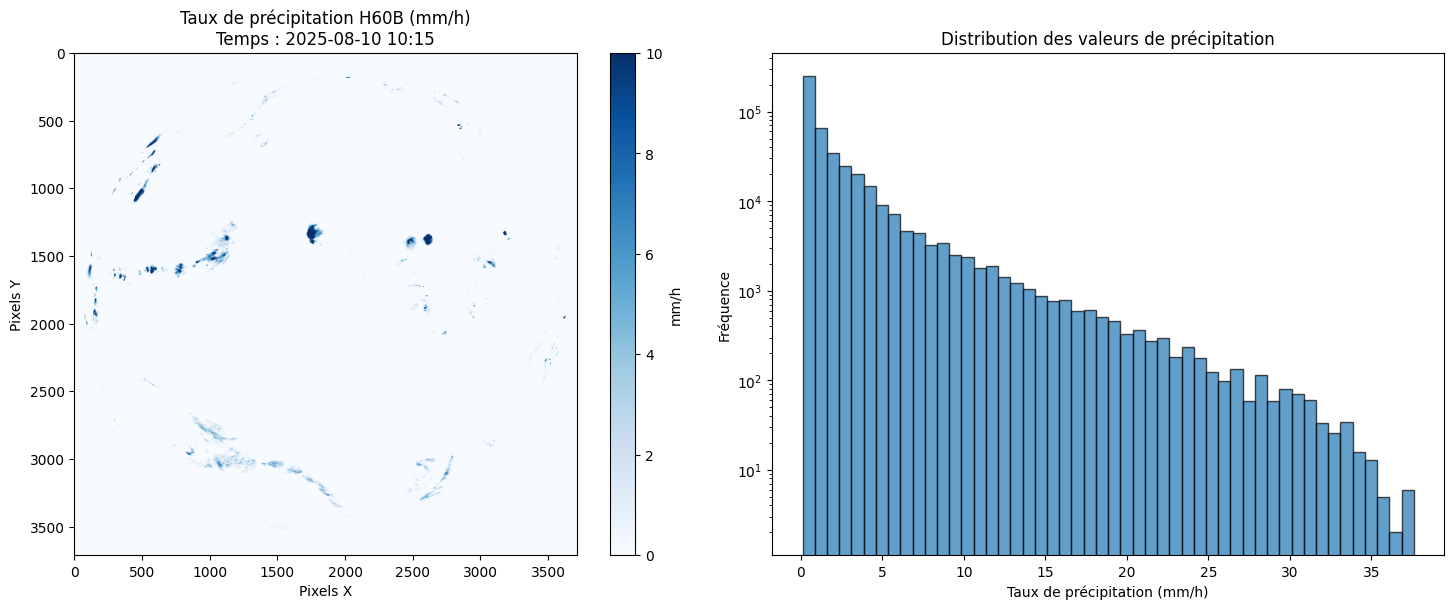


Statistiques de précipitation :
   Total de pixels : 13,778,944
   Pixels avec pluie (>0 mm/h) : 461,600
   Couverture de pluie : 4.6%
   Taux de pluie maximum : 37.6 mm/h
   Taux de pluie moyen (zones pluvieuses) : 1.96 mm/h


In [11]:
def plot_raw_data(ds, filename=None):
    """Créer une visualisation simple des données H60B brutes"""
    
    if ds is None:
        print("Aucun dataset à afficher")
        return
    
    # Extraire la date/heure depuis le nom du fichier si fourni
    if filename is not None:
        match = re.search(r'(\d{8})_(\d{4})', filename)
        if match:
            date_str, time_str = match.groups()
            timestamp = f"{date_str[:4]}-{date_str[4:6]}-{date_str[6:]} {time_str[:2]}:{time_str[2:]}"
        else:
            timestamp = "Inconnu"
    else:
        timestamp = "Inconnu"

    print(f"Affichage des données pour le fichier : {filename} (temps : {timestamp})")

    # Appliquer le facteur d'échelle: Cela est utilisé pour réduire l’espace de stockage, mais n’a aucune incidence sur les résultats.
    rr = ds['rr']
    scale_factor = rr.encoding.get('scale_factor', 0.1)
    add_offset = rr.encoding.get('add_offset', 0.0)
    precip = rr.astype('float32') * scale_factor + add_offset
    
    # Créez une figure.
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Carte des précipitations
    im1 = ax1.imshow(precip.values, cmap='Blues', vmin=0, vmax=10)
    ax1.set_title(f'Taux de précipitation H60B (mm/h)\nTemps : {timestamp}')
    ax1.set_xlabel('Pixels X')
    ax1.set_ylabel('Pixels Y')
    plt.colorbar(im1, ax=ax1, label='mm/h')
    
    # Histogramme
    valid_precip = precip.values[precip.values >= 0]
    ax2.hist(valid_precip[valid_precip > 0], bins=50, alpha=0.7, edgecolor='black')
    ax2.set_xlabel('Taux de précipitation (mm/h)')
    ax2.set_ylabel('Fréquence')
    ax2.set_title('Distribution des valeurs de précipitation')
    ax2.set_yscale('log')
    
    plt.tight_layout()
    plt.show()
    
    # Statistiques
    print(f"\nStatistiques de précipitation :")
    print(f"   Total de pixels : {precip.size:,}")
    print(f"   Pixels avec pluie (>0 mm/h) : {np.sum(valid_precip > 0):,}")
    print(f"   Couverture de pluie : {100 * np.sum(valid_precip > 0) / len(valid_precip):.1f}%")
    print(f"   Taux de pluie maximum : {np.max(valid_precip):.1f} mm/h")
    print(f"   Taux de pluie moyen (zones pluvieuses) : {np.mean(valid_precip[valid_precip > 0]):.2f} mm/h")

plot_raw_data(raw_dataset, filename=Path(downloaded_file).name)

Remarquez que la grille du satellite est en pixels X et Y, pas en latitude/longitude.
Chaque cellule du fichier H60B correspond à un pixel du capteur du satellite.
Si vous voulez utiliser ces données sur une carte géographique ou avec QGIS, il faudra les reprojeter pour obtenir des coordonnées latitude/longitude.

# Étape 9 : Prétraiter les données pour une grille latitude/longitude

Étapes principales :
1. Charger le fichier H60B brut
2. Appliquer les facteurs d’échelle et renommer la variable précipitation
3. Définir correctement le CRS (système de projection)
4. Créer des coordonnées spatiales cohérentes
5. Reprojeter les données vers WGS84 (latitude/longitude)
6. Définir les métadonnées globales et variables
7. Sauvegarder le fichier NetCDF prêt à l’usage

In [12]:
def preprocess_single_file(raw_file: str):
    """Prétraiter un fichier H60B unique pour WGS84 avec noms de variables cohérents."""
    filename = Path(raw_file).name

    # Extraire le timestamp depuis le nom du fichier et définir le chemin de sortie
    timestamp = parse_h60b_timestamp(filename)
    hsaf_filename = f"HSAF-H60B_{timestamp.strftime('%Y%m%dT%H%M%S')}.nc"
    output_path = processed_folder / hsaf_filename

    # Vérifier si le fichier prétraité existe déjà
    if output_path.exists():
        print(f"Fichier déjà prétraité : {hsaf_filename} -> Ignorer le prétraitement")
        return str(output_path)  # Retourner le chemin du fichier existant

    print(f"Prétraitement du fichier H60B : {filename} -> {hsaf_filename}")

    # --- Définitions des systèmes de coordonnées
    crs_in = "+proj=geos +a=6378.169 +b=6356.584 +h=35785.831 +lat_0=0 +lon_0=0.000000"  # CRS d’origine (satellite)
    crs_out = "EPSG:4326"  # CRS de sortie : latitude/longitude

    # Charger le fichier brut sans décodage automatique CF
    ds = xr.open_dataset(raw_file, decode_coords="all", decode_cf=False)

    # Renommer les coordonnées et appliquer le facteur d’échelle
    ds = ds.rename({"nx": "x", "ny": "y"})
    rr_raw = ds["rr"]
    scale_factor = rr_raw.encoding.get("scale_factor", 0.1)
    add_offset  = rr_raw.encoding.get("add_offset", 0.0)
    ds["rr"] = rr_raw.astype("float32") * scale_factor + add_offset
    ds["rr"].encoding.clear()
    ds["rr"].attrs.clear()
    ds = ds[["rr"]].astype("float32")

    # Utiliser le CRS directement depuis le fichier pour garder exact h, a, b, lon_0, etc.
    source_crs = CRS.from_proj4(ds.attrs["gdal_projection"])
    crs_in = source_crs.to_proj4()  # CRS exact du fichier
    crs_out = "EPSG:4326"

    # --- Définir l'étendue CGMS et les coordonnées
    cgms_projection = (
        "+proj=geos +coff=1856.000000 +cfac=13642337.000000 "
        "+loff=1856.000000 +lfac=13642337.000000 "
        "+spp=0.000000 +r_eq=6378.169000 +r_pol=6356.583800 +h=42164.000000"
    )
    matches = re.findall(r"\+?(\w+)\s*=\s*([^\s]+)", cgms_projection)
    parse_dict = {k: v for k, v in matches}

    # Calcul de l'étendue de la zone du satellite (area_extent)
    cd = source_crs.to_dict()
    area_extent = get_area_extent({
        "scandir": "N2S",                                                           # scandir : direction de balayage du satellite (N2S = Nord vers Sud)
        "h": float(parse_dict["h"]) * 1000 - float(parse_dict["r_eq"]) * 1000,      # h : hauteur du satellite au-dessus de la Terre       
        "loff": float(parse_dict["loff"]),                                          # loff, coff : décalages de ligne et de colonne (début du raster)
        "coff": float(parse_dict["coff"]),                                          
        "lfac": float(parse_dict["lfac"]),                                          # lfac, cfac : facteurs d'échelle pour les lignes et colonnes
        "cfac": float(parse_dict["cfac"]),
        "ncols": ds.x.size,                                                         # ncols, nlines : nombre de colonnes et lignes du raster
        "nlines": ds.y.size,
    })
    # Résultat : (min_x, max_x, min_y, max_y) dans la projection originale, utilisé pour reprojeter correctement le raster.

    area_def_src = AreaDefinition(
        "areaD",
        cd["proj"],
        "areaD",
        {"lon_0": cd["lon_0"], "a": cd["a"], "b": cd["b"], "h": cd["h"], "proj": cd["proj"]},
        ds.y.size,
        ds.x.size,
        (area_extent[0], area_extent[1], area_extent[2], area_extent[3]),
    )

    # Créer de nouvelles coordonnées X et Y
    x, y = area_def_src.get_proj_coords()
    new_x_coords = np.linspace(x.min(), x.max(), num=ds.sizes["x"])
    new_y_coords = np.linspace(y.max(), y.min(), num=ds.sizes["y"])
    ds = ds.assign_coords(y=("y", new_y_coords), x=("x", new_x_coords))

    # Écrire le CRS qui correspond aux unités des coordonnées
    ds = ds.rio.write_crs(crs_in)

    # Renommer la variable, ajouter le temps et trier les dimensions
    ds = ds.rename({"rr": "precip_intensity"}).sortby("y")
    ds = ds.expand_dims("time").assign_coords(time=("time", [timestamp]))
    ds = ds.transpose("time", "y", "x")

    # Définir les attributs de la variable de précipitation
    ds.precip_intensity.attrs = {
        "standard_name": "precipitation_flux",
        "long_name": "Flux de précipitation dérivé des propriétés optiques des nuages",
        "units": "kg m-2 h-1",
    }

    # Remplacer les valeurs invalides par NaN
    ds["precip_intensity"] = ds["precip_intensity"].where(ds["precip_intensity"] >= 0, np.nan)
    da = ds["precip_intensity"].rio.write_nodata(np.nan, encoded=True)
    ds["precip_intensity"] = da

    # Vérification rapide avant reprojection
    print("Avant reprojection : min/max", float(ds.precip_intensity.min()), float(ds.precip_intensity.max()))

    # Reprojection vers WGS84
    print("Reprojection des données H60B vers WGS84")
    ds = ds.rio.reproject(crs_out, nodata=np.nan)

    # Vérification après reprojection
    print("Après reprojection : min/max", float(ds.precip_intensity.min(skipna=True)), float(ds.precip_intensity.max(skipna=True)))

    # Nettoyer l'encodage après reprojection
    for var_name in ds.data_vars:
        ds[var_name].encoding.clear()
        for attr in ["_FillValue", "missing_value", "fill_value", "FillValue"]:
            ds[var_name].attrs.pop(attr, None)

    # Ordre final des dimensions
    ds = ds.transpose("time", "y", "x")

    # Définir les attributs CF pour les coordonnées
    ds.x.attrs = {"standard_name": "longitude", "long_name": "longitude", "units": "degrees_east", "axis": "X"}
    ds.y.attrs = {"standard_name": "latitude", "long_name": "latitude", "units": "degrees_north", "axis": "Y"}
    ds.time.attrs = {"standard_name": "time", "long_name": "time", "axis": "T"}

    # Définir les attributs globaux du dataset
    ds.attrs = {
        "Conventions": "CF-1.6",
        "title": "RAINSAT H60B MSG SEVIRI Precipitation",
        "source": "EUMETSAT H-SAF H60B",
        "creator": "HKV services",
        "creation_date": date.today().strftime("%Y-%m-%d"),
        "time_coverage_start": timestamp.strftime("%Y-%m-%dT%H:%M:%S"),
        "time_coverage_end": (timestamp + timedelta(minutes=15)).strftime("%Y-%m-%dT%H:%M:%S"),
        "geospatial_lat_min": float(ds.y.min()),
        "geospatial_lat_max": float(ds.y.max()),
        "geospatial_lon_min": float(ds.x.min()),
        "geospatial_lon_max": float(ds.x.max()),
        "crs": crs_out,
        "product_details": "https://hsaf.meteoam.it/Products/Detail?prod=H60B",
        "data_source": "hsaf-h60b",
    }

    # Encodage pour NetCDF
    encoding = {
        "precip_intensity": {"dtype": "float32", "zlib": True, "complevel": 4, "_FillValue": -999.0},
        "time": {"units": "minutes since 1970-01-01 00:00:00", "dtype": "float64"},
    }

    # Sauvegarder le fichier NetCDF prétraité
    ds.to_netcdf(output_path, encoding=encoding)
    ds.close()
    print(f"Fichier H60B prétraité avec succès : {hsaf_filename}")
    return str(output_path)

# Exécuter le prétraitement pour le fichier téléchargé
processed_file = preprocess_single_file(downloaded_file)

Fichier déjà prétraité : HSAF-H60B_20250810T101500.nc -> Ignorer le prétraitement


In [1]:
from pathlib import Path

processed_folder = Path("/workspaces/Tools-for-weather-and-climate-services-in-Africa/2_Créer_un_Nowcast_avec_HSAF_H60B/h60b_data/processed")
processed_folder.mkdir(parents=True, exist_ok=True)
print(processed_folder.exists(), processed_folder.is_dir())
print(processed_folder.stat().st_mode)


True True
16895


# Étape 10 : Visualiser les données prétraitées en latitude et longitude
Ici, nous allons créer deux graphiques côte à côte pour mieux comprendre les données prétraitées :
1. Nous réalisons une carte complète des précipitations (mm/h).
2. Nous mettons en évidence uniquement les zones pluvieuses (> 0,1 mm/h) afin de mieux visualiser où il pleut réellement.

En parallèle, nous affichons quelques statistiques résumées pour évaluer la qualité et l’étendue des données:
- La taille de la grille utilisée
- Le nombre de pixels valides
- Le nombre et la couverture des pixels pluvieux
- L’intensité maximale et moyenne de la pluie dans les zones pluvieuses

<xarray.Dataset> Size: 55MB
Dimensions:           (x: 3879, y: 3537, time: 1)
Coordinates:
  * x                 (x) float64 31kB -81.26 -81.22 -81.18 ... 81.22 81.26
  * y                 (y) float64 28kB 74.16 74.12 74.07 ... -73.99 -74.03
  * time              (time) datetime64[ns] 8B 2025-08-10T10:15:00
    spatial_ref       int64 8B ...
Data variables:
    precip_intensity  (time, y, x) float32 55MB ...
Attributes: (12/14)
    Conventions:          CF-1.6
    title:                RAINSAT H60B MSG SEVIRI Precipitation
    source:               EUMETSAT H-SAF H60B
    creator:              HKV services
    creation_date:        2025-08-29
    time_coverage_start:  2025-08-10T10:15:00
    ...                   ...
    geospatial_lat_max:   74.15732491263329
    geospatial_lon_min:   -81.25955346826284
    geospatial_lon_max:   81.26224267728661
    crs:                  EPSG:4326
    product_details:      https://hsaf.meteoam.it/Products/Detail?prod=H60B
    data_source:          hs

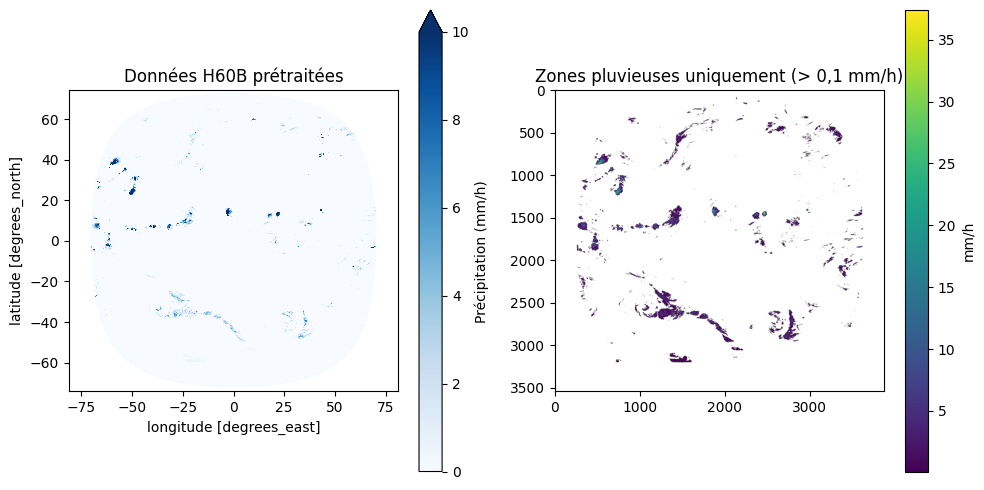


Résumé des données prétraitées :
   Temps : 2025-08-10T10:15:00.000000000
   Taille de la grille : 3537 x 3879 pixels
   Pixels valides : 10,124,295
   Pixels pluvieux (>0,1 mm/h) : 382,297
   Couverture pluvieuse : 3.78%
   Intensité maximale : 37.4 mm/h
   Intensité moyenne (zones pluvieuses) : 2.17 mm/h


In [14]:
def plot_processed_data(processed_file):
    """Visualiser les données de précipitation prétraitées"""
    
    # Charger le fichier NetCDF prétraité
    ds = xr.open_dataset(processed_file)
    print(ds)
    
    # Sélectionner le premier pas de temps (souvent unique pour H60B)
    precip = ds["precip_intensity"].isel(time=0)
    
    # Créer la figure avec deux sous-graphes côte à côte
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    
    # --- Graphe 1 : Carte complète des précipitations
    im1 = precip.plot(ax=ax1, cmap='Blues', vmin=0, vmax=10, 
                      cbar_kwargs={'label': 'Précipitation (mm/h)'})
    ax1.set_title('Données H60B prétraitées')
    ax1.set_aspect('equal')  # Assurer que les axes X et Y ont la même échelle
    
    # --- Graphe 2 : Zoom sur les zones pluvieuses uniquement
    rain_mask = precip.values > 0.1  # Zones avec > 0.1 mm/h
    if np.any(rain_mask):
        im2 = ax2.imshow(np.where(rain_mask, precip.values, np.nan), 
                        cmap='viridis', vmin=0.1)
        ax2.set_title('Zones pluvieuses uniquement (> 0,1 mm/h)')
        plt.colorbar(im2, ax=ax2, label='mm/h')
    else:
        # Affichage d’un message si aucune pluie significative
        ax2.text(0.5, 0.5, 'Aucune pluie\nsignificative détectée', 
                 ha='center', va='center', transform=ax2.transAxes)
        ax2.set_title('Zones pluvieuses uniquement')
    
    ax2.set_aspect('equal')
    
    plt.tight_layout()
    plt.show()
    
    # --- Statistiques résumées
    valid_data = precip.values[precip.values >= 0]  # Pixels valides
    rainy_data = valid_data[valid_data > 0.1]       # Pixels avec pluie > 0.1 mm/h
    
    print(f"\nRésumé des données prétraitées :")
    print(f"   Temps : {ds.time.values[0]}")
    print(f"   Taille de la grille : {precip.shape[0]} x {precip.shape[1]} pixels")
    print(f"   Pixels valides : {len(valid_data):,}")
    print(f"   Pixels pluvieux (>0,1 mm/h) : {len(rainy_data):,}")
    print(f"   Couverture pluvieuse : {100 * len(rainy_data) / len(valid_data):.2f}%")
    
    if len(rainy_data) > 0:
        print(f"   Intensité maximale : {np.max(rainy_data):.1f} mm/h")
        print(f"   Intensité moyenne (zones pluvieuses) : {np.mean(rainy_data):.2f} mm/h")

# Exécuter la visualisation si un fichier prétraité est disponible
if processed_file is not None:
    plot_processed_data(processed_file)

Remarque : vous pouvez observer l'effet de la projection d'une sphère sur une surface plane 
lorsque les données de la Terre (approximée comme une sphère) sont transformées en carte plate.


# Étape 11 : Boucle opérationnelle finale
Cette étape combine toutes les étapes précédentes dans une boucle unique pour un traitement complet automatique :
1. Téléchargement du fichier depuis le serveur FTP
2. Prétraitement du fichier pour le convertir en grille latitude/longitude
3. Enregistrement du fichier traité dans le dossier approprié

Cette boucle permet de traiter plusieurs fichiers H60B de manière séquentielle, sans intervention manuelle, ce qui est pratique pour les analyses opérationnelles ou les séries temporelles longues.

In [15]:
# Plus tôt dans ce notebook, vous avez choisi une période temporelle qui vous intéresse pour analyser les données HSAF. 
# Ces fichiers vont maintenant être utilisés dans la boucle suivante. Vous avez sélectionné les étapes temporelles suivantes :
selected_files

['h60_20250810_0800_fdk.nc.gz',
 'h60_20250810_0815_fdk.nc.gz',
 'h60_20250810_0830_fdk.nc.gz',
 'h60_20250810_0845_fdk.nc.gz',
 'h60_20250810_0900_fdk.nc.gz',
 'h60_20250810_0915_fdk.nc.gz',
 'h60_20250810_0930_fdk.nc.gz',
 'h60_20250810_0945_fdk.nc.gz',
 'h60_20250810_1000_fdk.nc.gz',
 'h60_20250810_1015_fdk.nc.gz']

In [16]:
# Boucle finale pour télécharger et prétraiter les fichiers sélectionnés
for selected_file in selected_files:
    # Déterminer le chemin du fichier téléchargé
    downloaded_file = download_h60b_file(selected_file)
    
    # Extraire le timestamp depuis le nom du fichier pour déterminer le fichier de sortie
    timestamp = parse_h60b_timestamp(Path(downloaded_file).name)
    hsaf_filename = f"HSAF-H60B_{timestamp.strftime('%Y%m%dT%H%M%S')}.nc"
    output_path = processed_folder / hsaf_filename

    # Vérifier si le fichier a déjà été prétraité
    if output_path.exists():
        print(f"{hsaf_filename} existe déjà, passage au fichier suivant\n" + "-"*40)
        continue

    # Prétraiter le fichier
    preprocess_single_file(downloaded_file)
    print(f"{selected_file} traité\n" + "-"*40)

Le fichier existe déjà : h60_20250810_0800_fdk.nc
Prétraitement du fichier H60B : h60_20250810_0800_fdk.nc -> HSAF-H60B_20250810T080000.nc
Avant reprojection : min/max 0.0 46.79999923706055
Reprojection des données H60B vers WGS84
Après reprojection : min/max 0.0 46.79999923706055
Fichier H60B prétraité avec succès : HSAF-H60B_20250810T080000.nc
h60_20250810_0800_fdk.nc.gz traité
----------------------------------------
Le fichier existe déjà : h60_20250810_0815_fdk.nc
Prétraitement du fichier H60B : h60_20250810_0815_fdk.nc -> HSAF-H60B_20250810T081500.nc
Avant reprojection : min/max 0.0 46.60000228881836
Reprojection des données H60B vers WGS84
Après reprojection : min/max 0.0 46.60000228881836
Fichier H60B prétraité avec succès : HSAF-H60B_20250810T081500.nc
h60_20250810_0815_fdk.nc.gz traité
----------------------------------------
Le fichier existe déjà : h60_20250810_0830_fdk.nc
Prétraitement du fichier H60B : h60_20250810_0830_fdk.nc -> HSAF-H60B_20250810T083000.nc
Avant reproje

# Étape 12 : Sélection et analyse des données HSAF pour une zone de votre choix
Les fichiers HSAF ont été téléchargés pour une très grande surface. Maintenant, nous allons zoomer et analyser les données pour une zone spécifique qui vous intéresse,
en utilisant les coordonnées de latitude et de longitude pour définir votre région d’intérêt.


In [17]:
# Étapes temporelles disponibles dans le dossier contenant les données de précipitation HSAF prétraitées. 
# Vous pouvez choisir parmi ces données celles que vous souhaitez visualiser.

file_list = sorted(processed_folder.glob("HSAF-H60B_*.nc"))
for f in file_list:
    print(f.name)

HSAF-H60B_20250810T080000.nc
HSAF-H60B_20250810T081500.nc
HSAF-H60B_20250810T083000.nc
HSAF-H60B_20250810T084500.nc
HSAF-H60B_20250810T090000.nc
HSAF-H60B_20250810T091500.nc
HSAF-H60B_20250810T093000.nc
HSAF-H60B_20250810T094500.nc
HSAF-H60B_20250810T100000.nc
HSAF-H60B_20250810T101500.nc


In [18]:
def plot_h60b_subset(processed_folder, filename=None, start_time=None, end_time=None, region=None, max_cols=5):
    """
    Visualiser les données H60B prétraitées pour une région donnée.
    - filename : afficher un fichier spécifique
    - start_time / end_time : afficher toutes les étapes de temps dans cet intervalle
    - region : dictionnaire avec lat_min, lat_max, lon_min, lon_max
    - max_cols : nombre maximal de colonnes par ligne pour les subplots
    """
    # Charger le dataset
    if filename is not None:
        ds = xr.open_dataset(processed_folder / filename)
    else:
        ds = xr.open_mfdataset(str(processed_folder / "HSAF-H60B_*.nc"))
    
    # Définir la région
    if region is None:
        region = {"lat_min": 4, "lat_max": 16, "lon_min": -6, "lon_max": 3}     # Ici, vous pouvez sélectionner une zone de votre choix.           
    
    ds_roi = ds.sel(
        x=slice(region["lon_min"], region["lon_max"]),
        y=slice(region["lat_max"], region["lat_min"])  # inversé pour y
    )
    
    # Filtrer par intervalle de temps
    if start_time is not None and end_time is not None:
        ds_roi = ds_roi.sel(time=slice(start_time, end_time))
    
    # Définir bornes et couleurs
    bounds = [0, 0.5, 2, 5, 10, 15, 25, 40, 100]                                # Ici, vous choisissez les intensités de précipitation à utiliser pour la barre de couleur dans la visualisation.
    colors = ["#ffffff", "#add8e6", "#0000ff", "#00ff00",
              "#ffff00", "#ffa500", "#ff0000", "#ff69b4"]
    cmap = mcolors.ListedColormap(colors)
    norm = mcolors.BoundaryNorm(bounds, cmap.N)
    
    # Nombre de pas de temps
    n_times = len(ds_roi.time)
    n_cols = min(n_times, max_cols)
    n_rows = math.ceil(n_times / max_cols)
    
    # Créer la figure avec le grid
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 5*n_rows), subplot_kw={'projection': ccrs.PlateCarree()})
    axes = np.array(axes).ravel()  # Pour itérer facilement

    # Boucle sur chaque pas de temps
    for t in range(n_times):
        ax = axes[t]
        subset = ds_roi.precip_intensity.isel(time=t)
        
        ax.add_feature(cfeature.BORDERS, linewidth=1)
        ax.add_feature(cfeature.COASTLINE, linewidth=1)
        ax.add_feature(cfeature.LAND, facecolor='lightgray')
        
        im = ax.pcolormesh(subset.x, subset.y, subset.values,
                           cmap=cmap, norm=norm, shading='auto')
        cbar = plt.colorbar(im, ax=ax, orientation='vertical', label='Précipitation (mm/h)')
        cbar.set_ticks(bounds)
        cbar.set_ticklabels([str(b) for b in bounds])
        
        ax.set_extent([region["lon_min"], region["lon_max"],
                       region["lat_min"], region["lat_max"]])
        
        time_str = np.datetime_as_string(subset.time.values, unit='m')
        ax.set_title(time_str)
    
    # Masquer les axes vides si moins de subplots que n_rows*n_cols
    for t in range(n_times, n_rows*n_cols):
        axes[t].axis('off')
    
    plt.tight_layout()
    plt.show()

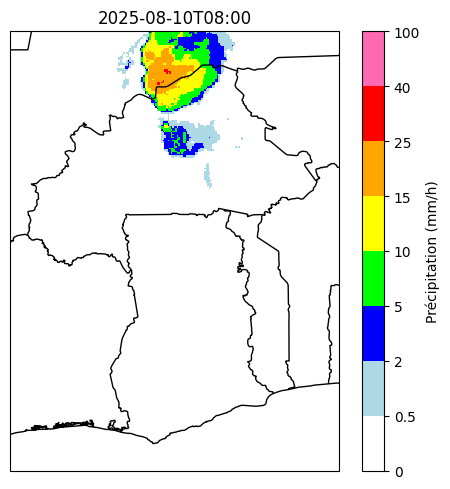

In [19]:
# Ici, nous appelons la fonction de visualisation pour une étape temporelle spécifique.
# Sélectionnez une étape dans la liste des fichiers présents dans le dossier des données traitées (processed data).
plot_h60b_subset(processed_folder, filename="HSAF-H60B_20250810T080000.nc")

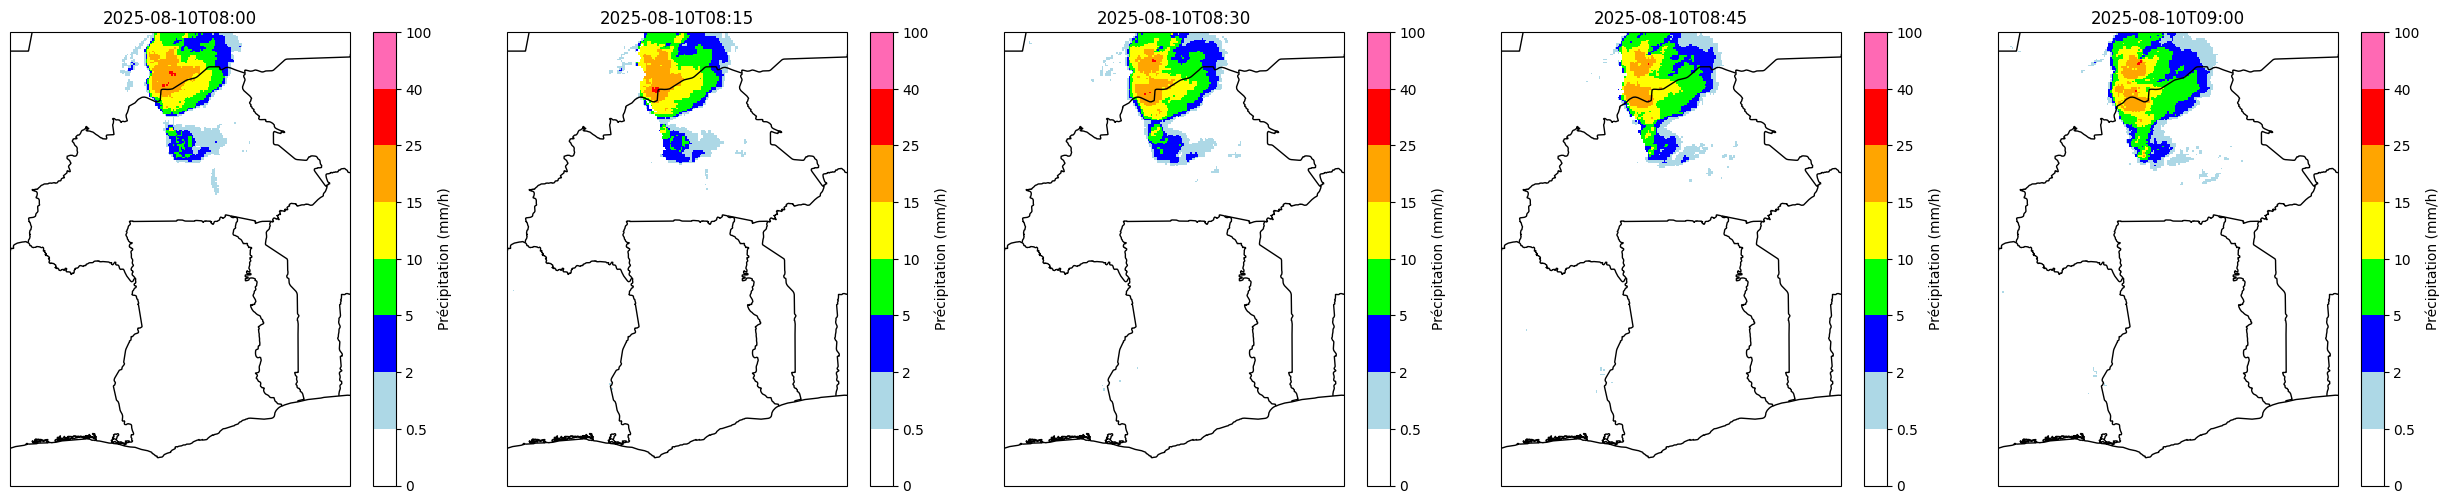

In [20]:
# Cette commande appelle la fonction `plot_h60b_subset` pour visualiser les données HSAF prétraitées.
# Elle va créer une visualisation pour un sous-ensemble de temps. Seules les étapes temporelles situées dans cet intervalle seront affichées.
plot_h60b_subset(
    processed_folder,
    start_time=datetime(2025, 8, 10, 8, 0),
    end_time=datetime(2025, 8, 10, 9, 0)
)

In [21]:
def animate_h60b_live(processed_folder, start_time=None, end_time=None, region=None):
    """
    Affiche une animation interactive des précipitations H60B pour un intervalle de temps donné.
    L'animation est affichée directement dans le notebook sans sauvegarde.
    """
    # Charger tous les fichiers H60B prétraités
    ds = xr.open_mfdataset(str(processed_folder / "HSAF-H60B_*.nc"))

    # Définir la région
    if region is None:
        region = {"lat_min": 4, "lat_max": 16, "lon_min": -6, "lon_max": 3}     # Ici, vous pouvez sélectionner une zone de votre choix. 
       
    ds_roi = ds.sel(
        x=slice(region["lon_min"], region["lon_max"]),
        y=slice(region["lat_max"], region["lat_min"])
    )
    
    # Filtrer par intervalle de temps
    if start_time is not None and end_time is not None:
        ds_roi = ds_roi.sel(time=slice(start_time, end_time))
    
    # Vérifier qu'il y a bien des données
    if len(ds_roi.time) == 0:
        print("Aucune donnée disponible pour l'intervalle sélectionné.")
        return
    
    bounds = [0, 0.5, 2, 5, 10, 15, 25, 40, 100]                                # Ici, vous choisissez les intensités de précipitation à utiliser pour la barre de couleur dans la visualisation.
    colors = ["#ffffff", "#add8e6", "#0000ff", "#00ff00",
              "#ffff00", "#ffa500", "#ff0000", "#ff69b4"]
    
    # Colormap et normalisation
    cmap = mcolors.ListedColormap(colors)
    norm = mcolors.BoundaryNorm(bounds, cmap.N)
    
    # Figure et axe
    fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={'projection': ccrs.PlateCarree()})
    plt.close(fig) 
    ax.add_feature(cfeature.BORDERS, linewidth=1)
    ax.add_feature(cfeature.COASTLINE, linewidth=1)
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.set_extent([region["lon_min"], region["lon_max"], region["lat_min"], region["lat_max"]])
    
    # Initialiser avec la première tranche de données
    subset0 = ds_roi.precip_intensity.isel(time=0)
    im = ax.pcolormesh(subset0.x, subset0.y, subset0.values,
                       cmap=cmap, norm=norm, shading='auto')
    cbar = plt.colorbar(im, ax=ax, orientation='vertical', label='Précipitation (mm/h)')
    cbar.set_ticks(bounds)
    cbar.set_ticklabels([str(b) for b in bounds])
    
    # Fonction de mise à jour pour l'animation
    def update(frame):
        subset = ds_roi.precip_intensity.isel(time=frame)
        im.set_array(subset.values)
        time_str = np.datetime_as_string(subset.time.values, unit='m')
        ax.set_title(f"Précipitations H60B - {time_str}")
        return [im]
    
    # Création de l'animation
    ani = FuncAnimation(fig, update, frames=len(ds_roi.time), blit=False, interval=1000)
    
    # Retourne l'animation pour affichage dans le notebook
    return HTML(ani.to_jshtml())

In [22]:
# Cette commande appelle la fonction `animate_h60b_live` pour créer une animation des données HSAF prétraitées.
# Elle va afficher l’évolution des précipitations dans le temps pour l’intervalle choisi.
# Chaque image de l’animation correspond à une étape temporelle dans cet intervalle, ce qui permet de visualiser la dynamique de la pluie.

animate_h60b_live(
    processed_folder,
    start_time=datetime(2025, 8, 10, 8, 0),
    end_time=datetime(2025, 8, 10, 16, 45)
)

<Figure size 640x480 with 0 Axes>

# Étape 13 : Extraction des précipitations HSAF pour des points spécifiques

In [24]:
# 1. Définir le dossier contenant les fichiers prétraités HSAF
processed_folder = Path("h60b_data/processed/")

# 2. Définir les points d'intérêt (latitude et longitude)
points = [
    {"nom": "Lomé", "lat": 6.13, "lon": 1.21},
    {"nom": "Ouagadougou", "lat": 12.37, "lon": -1.52},
    {"nom": "Nouna", "lat": 12.76, "lon": -3.84},
    # Ajouter d'autres points si nécessaire
]

# 3. Charger tous les fichiers HSAF prétraités
ds = xr.open_mfdataset(str(processed_folder / "HSAF-H60B_*.nc"))

# 4. Extraire les séries temporelles pour chaque point
data_dict = {}

for pt in points:
    # Sélection du pixel le plus proche du point choisi
    rain_series = ds.sel(
        x=ds["x"].sel(x=pt["lon"], method="nearest"),
        y=ds["y"].sel(y=pt["lat"], method="nearest")
    )["precip_intensity"]  
    
    # Stocker la série dans le dictionnaire avec le nom du point
    data_dict[pt["nom"]] = rain_series.values

# 5. Créer un dataframe : lignes = timestamps, colonnes = points
df_points = pd.DataFrame(data_dict, index=rain_series["time"].values)
df_points.index.nom = "time"  # Nommer l'index pour plus de clarté

# 6. Affichage du dataframe final
print("Dataframe final : chaque colonne est un point, chaque ligne est un timestamp")
df_points

# 7. Sauvegarder le dataframe comme fichier Excel dans le même dossier que le notebook
excel_path = Path(".") / "hsaf_points_timeseries.xlsx"
df_points.to_excel(excel_path, index=True)
print(f"Dataframe sauvegardé dans {excel_path}")

Dataframe final : chaque colonne est un point, chaque ligne est un timestamp
Dataframe sauvegardé dans hsaf_points_timeseries.xlsx


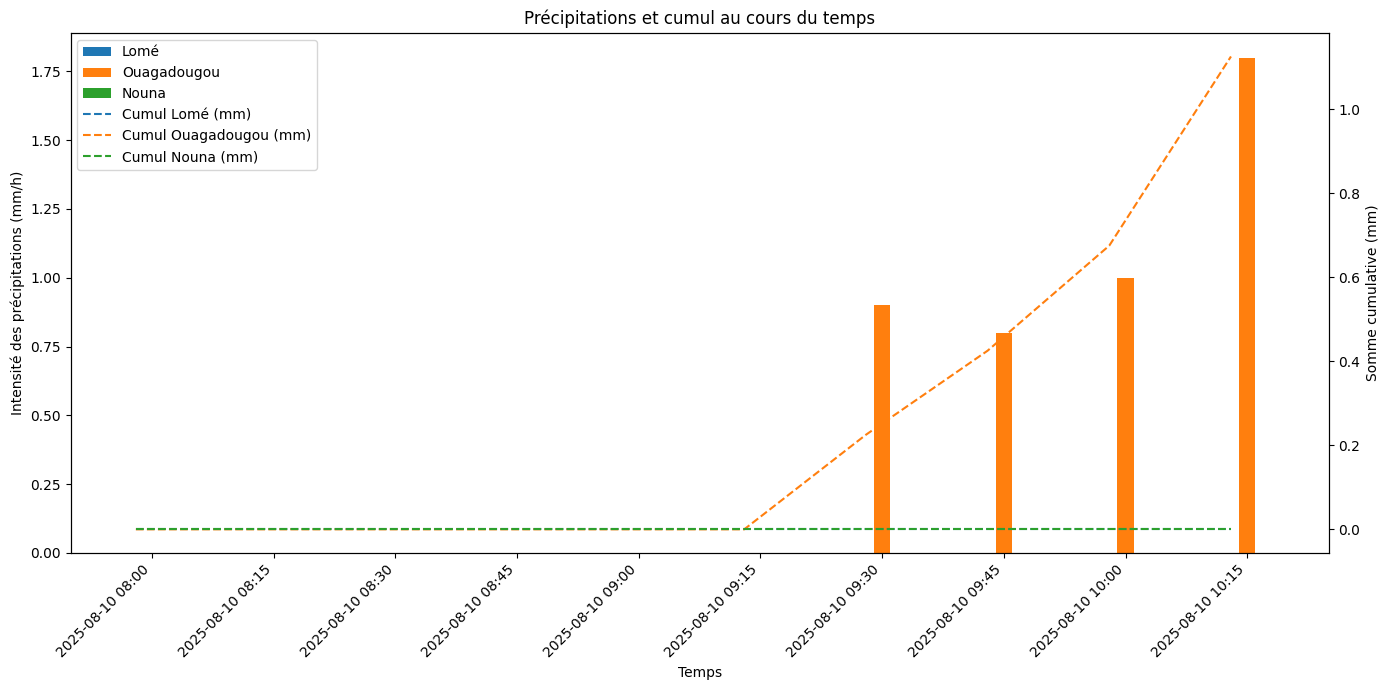

In [25]:
#  Création du graphique avec barres (intensité) et courbes (cumul corrigé)
fig, ax1 = plt.subplots(figsize=(14, 7))

# Création d’un vecteur pour l’axe des X
x = np.arange(len(df_points.index))
width = 0.4 / len(df_points.columns)  # largeur des barres par point

# Tracer les barres pour chaque point (intensité en mm/h)
for i, col in enumerate(df_points.columns):
    ax1.bar(
        x + i * width,                # Décalage des barres
        df_points[col].values,        # Valeurs d’intensité (mm/h)
        width=width, 
        label=col
    )

# Mise en forme de l’axe X avec les timestamps
ax1.set_xticks(x + width * (len(df_points.columns) - 1) / 2)
ax1.set_xticklabels(df_points.index.strftime("%Y-%m-%d %H:%M"), rotation=45, ha="right")

ax1.set_ylabel("Intensité des précipitations (mm/h)")
ax1.set_xlabel("Temps")

# Conversion en mm par pas de 15 minutes
df_points_mm = df_points * 0.25   # mm/h * 0.25 = mm/15min

# Ajouter un second axe Y pour les cumuls
ax2 = ax1.twinx()
for col in df_points.columns:
    ax2.plot(
        x, 
        df_points_mm[col].cumsum(), linestyle="--",
        label=f"Cumul {col} (mm)"
    )

ax2.set_ylabel("Somme cumulative (mm)")

# Fusion des légendes (barres + courbes)
lines_labels = [ax.get_legend_handles_labels() for ax in [ax1, ax2]]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
ax1.legend(lines, labels, loc="upper left")

plt.title("Précipitations et cumul au cours du temps")
plt.tight_layout()
plt.show()